# PT Gradient

An example of how to compute the derivative of an objective function of the final state with respect to a set of system parameters or 'controls' using the OQuPy package. A more detailed explanation of the method can be found in the supplement [Butler2023] (https://arxiv.org/abs/2303.16002).
* [launch binder](https://mybinder.org/v2/gh/tempoCollaboration/OQuPy/HEAD?labpath=tutorials%2Fpt_gradient.ipynb) 
* [download the jupyter file](https://raw.githubusercontent.com/tempoCollaboration/OQuPy/main/tutorials/pt_gradient.ipynb)
* read through the text below and code along

The following packages are required

In [1]:
import sys
sys.path.insert(0,'..')
import numpy as np
import oqupy
from oqupy import operators as op
import matplotlib.pyplot as plt

The OQuPy version should be `>=v0.5.0`

In [2]:
oqupy.__version__

'0.4.0'

# Contents 

* [0. Introduction](#introduction)

* [1. Example : Spin Boson Model](#example---spin-boson-model)
    - [1.1 System](#1-system-definition)

    - [1.2 Process Tensor generation](#2-process-tensor-generation)

    - [1.3 Objective Function : The Fidelity](#3-objective-function-the-fidelity)
    
    - [1.4 Adjoint method](#4-adjoint-method)


# Introduction

<a id='introduction'></a>

The process tensor approach to open quantum systems allows to efficiently optimize control protocols of non-Markovian open quantum systems (see [Fux2020, Butler2023]). For this one first computes the process tensor in MPO form of the given environment interaction and then repeatedly applies different time-dependent system Hamiltonians. This has the advantage that each trial system Hamiltonian can be applied with minimal computational efford to the same precomputed process tensor.

Such a computation of the open dynamics for a set of different time-dependent system Hamiltonians is demonstrated in the tutorial "Time dependence and PT-TEMPO". The search for an optimal protocol can, however, be accelerated drastically by computing the gradient of the objective function with respect to some parametrization of the system Hamiltonian.

In this tutorial we demonstrate the computation of the gradient of some generic objective function $Z(\rho_f)$ which only depends on the value of the final density matrix $\rho_f$. Let's assume that we parametrize the system Hamiltonian with $M$ parameters each at time step. The derivative of the objective function $Z$ with respect to the $m^\mathrm{th}$ parameter at the $n^\mathrm{th}$ time step $c_m^n$ is 
$$
\frac{\partial Z}{\partial c_m^n}=\sum_{i,j,k}^{d_{H_S}^2}
\frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}
\frac{\partial U^{jk}_n}{\partial c_m^n},
$$
Where $U_n$ are the Liouville system propagators given by the system Hamiltonian at time step $n$.
This expression is depicted diagramatically in Fig S2 of the supplement in reference [Butler2023].

The three terms in the product are understood as follows:
1. $\frac{\partial Z}{\partial \rho_f^i}$ : The derivative of the objective function with respect to the final state. This is computed analytically and corresponds to rank-1 tensor in Liouville space.
2. $\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ : The derivative of the final state with respect to the propagator at the $n^{\text{th}}$ time-step. Due to the linearity of our network, this is the same as the diagram for the time-evolution of the initial state after $N_t$ steps with the propagator(s) at the $n^{\text{th}}$ timestep removed. The rank of this tensor depends on the order of the Trotterization of the propagators. PT-TEMPO implements a second-order splitting, such that the tensors are rank-$4$.
3. $\frac{\partial U^{jk}_n}{\partial c_m}$ : The derivative of a propagator at the $n^{\text{th}}$ timestep with respect to $m^\mathrm{th}$ control parameter at the $n^\text{th}$ timestep. Due to the second Trotterization, there are $2 N$ half-propagators and therefore $2 N$ half-propagator derivatives. These are computed via finite-difference and are of rank-$2$. 

Expression 2. is not calculated directly. Rather, we perform a forward propagation of the initial state $\rho_0$ and back propagation of the target derivative $\frac{\partial Z}{\partial \rho_f^i}$ for $n$ time-steps. The stored tensors are of rank-$2$ with an external 'system' leg which connects to the propagators and an internal 'bond' leg connecting to the PT-MPOs. By joining the bond legs of the appropriate tensors from the forward and back propagations we obtain the rank-$4$ tensor $ \frac{\partial Z}{\partial \rho_f^i}
\frac{\partial\rho_f^i}{\partial U^{jk}_n}$ which, when contracted with the propagator derivatives $\frac{\partial U^{jk}_n}{\partial c_m}$, gives $\frac{\partial Z}{\partial c_m^n}$.

As an example, we model a spin-boson system coupled to an external field and compute the gradient with respect to each parameter.

# Example - Spin Boson Model

### 1. System Definition

We choose the system modelled in the supplement, a spin-boson model representing a quantum-dot driven by a laser pulse. We consider a time-dependent system Hamiltonian 
$$
H_S = h_x(t) \sigma_x + h_z(t) \sigma_z ,
$$
where the parameters $h_x(t)$ and $h_z(t)$ represent a set of fields controlling the system dynamics. This means we parametrize the system Hamiltonian with two parameters at each time step, i.e. $m\in\{x,z\}$ and $c_m^n = h_m(n\, \delta t)$. A system of this type is represented by a `ParameterizedSystem` object. This object requires a Callable which returns the Hamiltonian for specific parameters. It encapsulates the system dynamics via calculation of the propagators $U^{ij}$ and propagator derivatives $\frac{\partial U^{ij}_n}{\partial c_m^n}$ using the functions `get_propagators` and `get_propagator_derivatives` respectively.

In [3]:
# function which returns system Hamiltonian for a given set of parameters
def discrete_hamiltonian(hx,hz):
    return hx*op.sigma('x') + hz*op.sigma('z')

# definition of parameterized system
system = oqupy.ParameterizedSystem(discrete_hamiltonian)

We then provide a $(2*N,M)$-dimensional tuple of parameters which define the value of the fields at each half time-step. For simplicity, we choose a pair of constant fields $h_x=0$ and $h_z=\pi/T$. We choose a pulse duration $T=5 \text{ps}^{-1}$ and model over $100$ timesteps. We work in Planck units throughout ($\hbar = k_B = 1$) and take $\text{ps}^{-1}$ as units of angular momentum.

In [4]:
max_time = 5.0
N = 50 # number of time steps
dt = max_time/N

In [5]:
h_z = np.ones(2*N) * np.pi / (2 * max_time)
h_x = np.zeros(2*N)
parameters = np.vstack((h_x,h_z)).T
parameters.shape

(100, 2)

### 2. Process Tensor generation

The bath and interaction Hamiltonians are 
$$
H_B = \sum_k \omega_k b_k^\dag b_k 
$$
and 
$$
H_{SB} = \frac{1}{2} \sigma_z \sum_k (g_k b_k^\dag + g^*_k b_k),
$$
respectively. The bath interaction terms $g_k$ and $\omega_k$ are characterised by the super-ohmic spectral density
$$
J(\omega)  = 2 \alpha \omega^3 \omega_c^{-2} \text{exp}(- \frac{\omega^2}{\omega^2_c}).
$$
with $\omega_c=3.04 \text{p s}^{-1}$ and $\alpha=0.126$.
We take the bath to be at $T=5 \text{K}$. The process tensor is then generated as follows.

In [6]:
# spectral density parameters
alpha = 0.126
omega_cutoff = 3.04
temperature = 5 * 0.1309 # 1K = 0.1309/ps in natural units

# numerical tempo parameters
tcut  = 2.0
esprel = 10**(-4)

correlations = oqupy.PowerLawSD(
    alpha=alpha,
    zeta=3,
    cutoff=omega_cutoff,
    cutoff_type='gaussian',
    temperature=temperature)
bath = oqupy.Bath(op.sigma("z")/2, correlations)

tempo_params = oqupy.TempoParameters(dt=dt, tcut=tcut, epsrel=esprel)

In [7]:
# process tensor creation
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0,
    end_time=max_time,
    parameters=tempo_params
    )

--> PT-TEMPO computation:
  8.0%    4 of   50 [###-------------------------------------] 00:00:00

100.0%   50 of   50 [########################################] 00:00:01
Elapsed time: 1.4s


### 3. Objective Function: The Fidelity

For our objective function, we choose the fidelity $\mathcal{F(\rho_t,\rho_f)}$ between a target state $\rho_t$ and the final state $\rho_f$. For simplicity, we consider a pure target state $\rho_t = \ket{\sigma}\bra{\sigma}$ such that $\mathcal{F}=\bra{\sigma} \rho_f \ket{\sigma}$. In Liouville space, this is expressed as $\mathcal{F} = \langle \langle \rho_t^T | \rho_f \rangle \rangle = \sum_i^{d_H^2} \rho^T_{t,i} \rho_{f,i}$, where $| \cdot  \rangle \rangle$ denotes a vectorized density matrix and $d_H$ the Hilbert space dimension. The derivative with respect to the final state is then 
$$
\frac{\partial \mathcal{F}}{\partial \rho_f} = \rho_t^T.
$$
We model the state transfer between an initial state $\rho_0=\ket{x+} \bra{x+}$ and target state $\rho_t=\ket{x-} \bra{x-}$.

In [8]:
initial_state = op.spin_dm('x+')
target_state = op.spin_dm('x-')
target_derivative = target_state.T

### 4. Adjoint Method

Now that we have defined our objective function, environment and system, we are able to perform back propagation in order to compute the gradient and dynamics. This is done via `state_gradient`. The function computes $\{\rho(t_n) \}_{n=0,..,N-1}$ and $\{ \frac{\partial Z}{\partial \rho_f^i}\frac{\partial\rho_f^i}{\partial U^{jk}_n} \}_{n=0,...,2N-1}$ using a forward and back propagation of $\rho_0$ and $ \frac{\partial Z}{\partial \rho_f}$ as outlined in the introduction. It then calculates the propagators and propagator derivatives $\frac{\partial U^{ij}_n}{\partial c_m^n}$ using the parameters and `ParameterizedSystem` object. These are finally combined as in the chain rule to get the derivative of the objective function with respect to each parameter at each timestep $\{ \frac{\partial Z}{\partial c_m^n} \}_{m=\{0,...,M-1\},\,n=\{0,...,2N-1\}}$. The dictionary returned contains:
* `gradient` : the list of gradients $\{ \frac{\partial Z}{\partial c_m^n} \}_{m=\{0,...,M-1\},\,n=\{0,...,2N-1\}}$ at each half time-step
* `gradprop` : the list of tensors $\{ \frac{\partial Z}{\partial \rho_f^i}\frac{\partial\rho_f^i}{\partial U^{jk}_n} \}_{n=0,...,N-1}$ 
* `dynamics` : the states and times
* `final state` : the final state 

In [9]:
# forward-backpropagation + combination of derivatives
grad_res = oqupy.state_gradient(
    system=system,
    initial_state=initial_state,
    target_derivative=target_derivative,
    process_tensors=[process_tensor],
    parameters=parameters)

--> Compute forward propagation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.3s
--> Compute backward propagation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.3s
--> Apply chain rule:
100.0%   50 of   50 [########################################] 00:00:08
Elapsed time: 8.0s


We can now plot the dynamics and the gradient:

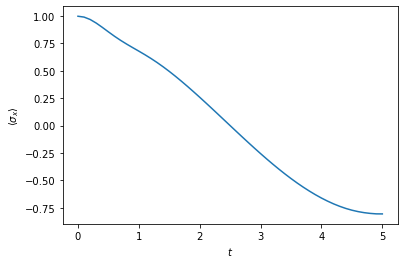

The fidelity is 0.9012528539245432.


In [10]:
plt.plot(*grad_res['dynamics'].expectations(op.sigma('x'), real=True))
plt.ylabel(r"$\langle \sigma_x \rangle$")
plt.xlabel(r"$t$")
plt.show()
fidelity = np.real(grad_res['final_state'].flatten() @ target_state.flatten())
print(f"The fidelity is {fidelity}.")

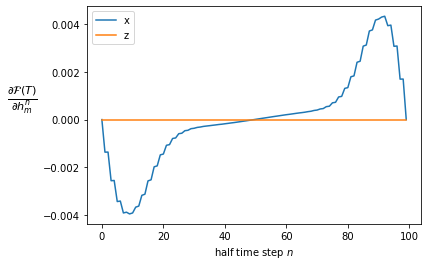

In [11]:
plt.figure()
plt.plot(grad_res['gradient'][:,0].real,label='x')
plt.plot(grad_res['gradient'][:,1].real,label='z')
plt.legend()
plt.ylabel(r"$\frac{\partial \mathcal{F}(T)}{\partial h_m^n}$",
           rotation=0,fontsize=16,labelpad=20)
plt.xlabel(r"half time step $n$")
plt.show()


Voilà, we have computed the gradient! We can easily plug in another set of system parameters and rerun the calculation to get the gradient for a different field. This is particularly useful for optimisation of the objective function because the long calculation of the process tensor is done only once. We can do lots of faster calculations of $Z$ and $\frac{\partial Z}{\partial c_m}$ for different system parameters until we find an 'optimal' (minima/maxima of $Z$ within some tolerance) set of controls.